#### Magic Commands
Magic commands (those that start with `%`) are commands that modify a configuration of Jupyter Notebooks. A number of magic commands are available by default (see list [here](http://ipython.readthedocs.io/en/stable/interactive/magics.html))--and many more can be added with extensions. The magic command added in this section allows `matplotlib` to display our plots directly on the browser instead of having to save them on a local file.

In [1]:
%matplotlib inline

# Activity 7: Optimizing a deep learning model
In this activity we optimize our deep learning model. We aim achieve greater performance than our model `bitcoin_lstm_v0`, which is off at about **8.4%** from the real Bitcoin prices. We explore the following topics in this notebook:

* Experimenting with different layers and the number of nodes
* Grid search strategy for epoch and activation functions

In [2]:
import math
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

In [3]:
from keras.models import load_model
from keras.models import Sequential
from keras.layers.recurrent import LSTM
from keras.callbacks import TensorBoard
from keras.layers.core import Dense, Activation, Dropout, ActivityRegularization

In [6]:
import random
import numpy as np

from matplotlib import pyplot as plt
from keras.callbacks import TensorBoard


def create_groups(data, group_size=7):
    """Create distinct groups from a continuous series.

    Parameters
    ----------
    data: np.array
        Series of continious observations.

    group_size: int, default 7
        Determines how large the groups are. That is,
        how many observations each group contains.

    Returns
    -------
    A Numpy array object.
    """
    samples = list()
    for i in range(0, len(data), group_size):
        sample = list(data[i:i + group_size])
        if len(sample) == group_size:
            samples.append(np.array(sample).reshape(1, group_size).tolist())

    a = np.array(samples)
    return a.reshape(1, a.shape[0], group_size)


def split_lstm_input(groups):
    """Split groups in a format expected by the LSTM layer.

    Parameters
    ----------
    groups: np.array
        Numpy array with the organized sequences.

    Returns
    -------
    X, Y: np.array
        Numpy arrays with the shapes required by
        the LSTM layer. X with (1, a - 1, b)
        and Y with (1, b). Where a is the total
        number of groups in `group` and b the
        number of observations per group.
    """
    X = groups[0:, :-1].reshape(1, groups.shape[1] - 1, groups.shape[2])
    Y = groups[0:, -1:][0]

    return X, Y


def mape(A, B):
    """Calculate the mean absolute percentage error from two series."""
    return np.mean(np.abs((A - B) / A)) * 100


def rmse(A, B):
    """Calculate the root mean square error from two series."""
    return np.sqrt(np.square(np.subtract(A, B)).mean())


def train_model(model, X, Y, epochs=100, version=0, run_number=0):
    """Shorthand function for training a new model.

    This function names each run of the model
    using the TensorBoard naming conventions.

    Parameters
    ----------
    model: Keras model instance
        Compiled Keras model.

    X, Y: np.array
        Series of observations to be used in
        the training process.

    version: int
        Version of the model to run.

    run_number: int
        The number of the run. Used in case
        the same model version is run again.
    """
    hash = random.getrandbits(128)
    hex_code = '%032x' % hash
    model_name = f'bitcoin_lstm_v{version}_run_{run_number}_{hex_code[:6]}'

    tensorboard = TensorBoard(log_dir=f'./logs/{model_name}')

    model_history = model.fit(
        x=X, y=Y,
        batch_size=1, epochs=epochs,
        callbacks=[tensorboard],
        shuffle=False)

    return model_history


def plot_two_series(A, B, variable, title):
    """Plot two series using the same `date` index.

    Parameters
    ----------
    A, B: pd.DataFrame
        Dataframe with a `date` key and a variable
        passed in the `variable` parameter. Parameter A
        represents the "Observed" series and B the "Predicted"
        series. These will be labelled respectivelly.

    variable: str
        Variable to use in plot.

    title: str
        Plot title.
    """
    plt.figure(figsize=(14, 4))
    plt.xlabel('Observed and predicted')

    ax1 = A.set_index('date')[variable].plot(
        color='#d35400', grid=True, label='Observed', title=title)

    ax2 = B.set_index('date')[variable].plot(
        color='grey', grid=True, label='Predicted')

    ax1.set_xlabel("Predicted Week")
    ax1.set_ylabel("Predicted Values")

    plt.legend()
    plt.show()


def denormalize(reference, series,
                normalized_variable='close_point_relative_normalization',
                denormalized_variable='close'):
    """Denormalize the values for a given series.

    Parameters
    ----------
    reference: pd.DataFrame
        DataFrame to use as reference. This dataframe
        contains both a week index and the USD price
        reference that we are interested on.

    series: pd.DataFrame
        DataFrame with the predicted series. The
        DataFrame must have the same columns as the
        `reference` dataset.

    normalized_variable: str, default 'close_point_relative_normalization'
        Variable to use in normalization.

    denormalized_variable: str, default `close`
        Variable to use in de-normalization.

    Returns
    -------
    A modified DataFrame with the new variable provided
    in `denormalized_variable` parameter.
    """
    week_values = reference[reference['iso_week'] == series['iso_week'].values[0]]
    last_value = week_values[denormalized_variable].values[0]
    series[denormalized_variable] = last_value * (series[normalized_variable] + 1)

    return series


In [7]:
plt.style.use('seaborn-white')

In [8]:
np.random.seed(0)

### Load Data
We will load our same train and testing set from previous activitites. 

In [10]:
train = pd.read_csv('train_dataset.csv')

In [12]:
test = pd.read_csv('test_dataset.csv')

In [13]:
train_data = create_groups(
    train['close_point_relative_normalization'].values)

In [14]:
test_data = create_groups(
    test['close_point_relative_normalization'].values)

In [15]:
X_train, Y_train = split_lstm_input(train_data)

### Reference Model
For reference, let's load data for `v0` of our model and train it alongside future modifications.

In [16]:
model_v0 = load_model('bitcoin_lstm_v0.h5')

In [17]:
%%time
train_model(model=model_v0, X=X_train, Y=Y_train, epochs=100, version=0, run_number=0)

Epoch 1/100
1/1 [==============================] - 0s 151ms/step - loss: 0.0086
Epoch 2/100
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
1/1 [==============================] - 0s 42ms/step - loss: 0.0075
Epoch 3/100
1/1 [==============================] - 0s 25ms/step - loss: 0.0068
Epoch 4/100
1/1 [==============================] - 0s 71ms/step - loss: 0.0063
Epoch 5/100
1/1 [==============================] - 0s 63ms/step - loss: 0.0058
Epoch 6/100
1/1 [==============================] - 0s 27ms/step - loss: 0.0054
Epoch 7/100
1/1 [==============================] - 0s 41ms/step - loss: 0.0050
Epoch 8/100
1/1 [==============================] - 0s 29ms/step - loss: 0.0047
Epoch 9/100
1/1 [==============================] - 0s 38ms/step - loss: 0.0044
Epoch 10/100
1/1 [==============================] - 0s 34ms/step - loss: 0.0041
Epoch 11/100
1/1 [==============================] - 0s 60ms/step - loss: 0.0039
Epoch 12/100
1/1 [==============================] - 0s 7

1/1 [==============================] - 0s 26ms/step - loss: 9.9896e-06
Epoch 97/100
1/1 [==============================] - 0s 26ms/step - loss: 8.5946e-06
Epoch 98/100
1/1 [==============================] - 0s 21ms/step - loss: 7.1356e-06
Epoch 99/100
1/1 [==============================] - 0s 24ms/step - loss: 6.2258e-06
Epoch 100/100
1/1 [==============================] - 0s 20ms/step - loss: 5.5841e-06
Wall time: 22.7 s


### Adding Layers and Nodes
We can modify our model to include other layers now. When using LSTM cells, one typically adds other LSTM layer in a sequence. In our case the layer will have the same number of neurons as the original layer.

In order for this to work, however, we need to modify the parameter `return_sequences` to `True` on the first LSTM layer. We do this because the first layer expects a sequence of data with the same as input that the of the first layer. When this parameter is set to `False` the LSTM layer outputs the predicted parameters in a different incompatible output.

In [18]:
period_length = 7
number_of_periods = 76
batch_size=1

In [20]:
model_v1 = Sequential()
model_v1.add(LSTM(
    units=period_length,
    batch_input_shape=(batch_size, number_of_periods, period_length),
    input_shape=(number_of_periods, period_length),
    return_sequences=True, stateful=False))

#
#  Add new LSTM layer to this network here.
#

model_v1.add(Dense(units=period_length))
model_v1.add(Activation("linear"))

model_v1.compile(loss="mse", optimizer="rmsprop")

In [21]:
%%time
train_model(model=model_v1, X=X_train, Y=Y_train, epochs=100, version=1, run_number=0)

Epoch 1/100
1/1 [==============================] - 0s 75ms/step - loss: 0.0065
Epoch 2/100
1/1 [==============================] - 0s 40ms/step - loss: 0.0054
Epoch 3/100
1/1 [==============================] - 0s 20ms/step - loss: 0.0049
Epoch 4/100
1/1 [==============================] - 0s 32ms/step - loss: 0.0044
Epoch 5/100
1/1 [==============================] - 0s 34ms/step - loss: 0.0041
Epoch 6/100
1/1 [==============================] - 0s 39ms/step - loss: 0.0038
Epoch 7/100
1/1 [==============================] - 0s 23ms/step - loss: 0.0035
Epoch 8/100
1/1 [==============================] - 0s 34ms/step - loss: 0.0032
Epoch 9/100
1/1 [==============================] - 0s 30ms/step - loss: 0.0030
Epoch 10/100
1/1 [==============================] - 0s 25ms/step - loss: 0.0027
Epoch 11/100
1/1 [==============================] - 0s 37ms/step - loss: 0.0025
Epoch 12/100
1/1 [==============================] - 0s 30ms/step - loss: 0.0023
Epoch 13/100
1/1 [==============================]

1/1 [==============================] - 0s 58ms/step - loss: 8.7813e-05
Epoch 100/100
1/1 [==============================] - 0s 39ms/step - loss: 8.5551e-05
Wall time: 12.9 s


### Epochs
Epochs are the number of times the network adjust its weights in response to data passing through and its loss function. Running a model for more epochs can allow it to learn more from data, but you also run the risk of overfitting.

When training a model, prefer to increase the epochs exponentially until the loss function starts to plateau. In the case of the `bitcoin_lstm_v0` model, its loss function plateaus at about 100 epochs. If one attempts to train it at 10^3 epochs, the model barely gains any improvements.

In [22]:
#
#  Change the number of epochs below
#  to a higher number (try 10**3) and
#  evaluate the results on TensorBoard.
#
number_of_epochs = 300

In [23]:
model_v2 = Sequential()
model_v2.add(LSTM(
    units=period_length,
    batch_input_shape=(batch_size, number_of_periods, period_length),
    input_shape=(number_of_periods, period_length),
    return_sequences=True, stateful=False))

model_v2.add(LSTM(
    units=period_length,
    batch_input_shape=(batch_size, number_of_periods, period_length),
    input_shape=(number_of_periods, period_length),
    return_sequences=False, stateful=False))

model_v2.add(Dense(units=period_length))
model_v2.add(Activation("linear"))

model_v2.compile(loss="mse", optimizer="rmsprop")

In [24]:
%%time
train_model(model=model_v2, X=X_train, Y=Y_train, epochs=number_of_epochs, 
            version=2, run_number=0)

Epoch 1/300
1/1 [==============================] - 0s 49ms/step - loss: 0.0064
Epoch 2/300
1/1 [==============================] - 0s 42ms/step - loss: 0.0055
Epoch 3/300
1/1 [==============================] - 0s 40ms/step - loss: 0.0050
Epoch 4/300
1/1 [==============================] - 0s 38ms/step - loss: 0.0045
Epoch 5/300
1/1 [==============================] - 0s 71ms/step - loss: 0.0041
Epoch 6/300
1/1 [==============================] - 0s 38ms/step - loss: 0.0038
Epoch 7/300
1/1 [==============================] - 0s 33ms/step - loss: 0.0035
Epoch 8/300
1/1 [==============================] - 0s 34ms/step - loss: 0.0032
Epoch 9/300
1/1 [==============================] - 0s 37ms/step - loss: 0.0029
Epoch 10/300
1/1 [==============================] - 0s 33ms/step - loss: 0.0027
Epoch 11/300
1/1 [==============================] - 0s 51ms/step - loss: 0.0025
Epoch 12/300
1/1 [==============================] - 0s 49ms/step - loss: 0.0023
Epoch 13/300
1/1 [==============================]

1/1 [==============================] - 0s 73ms/step - loss: 2.2131e-05
Epoch 100/300
1/1 [==============================] - 0s 80ms/step - loss: 2.7544e-05
Epoch 101/300
1/1 [==============================] - 0s 169ms/step - loss: 2.1293e-05
Epoch 102/300
1/1 [==============================] - 0s 99ms/step - loss: 1.6782e-05
Epoch 103/300
1/1 [==============================] - 0s 124ms/step - loss: 1.1821e-05
Epoch 104/300
1/1 [==============================] - 0s 63ms/step - loss: 1.1091e-05
Epoch 105/300
1/1 [==============================] - 0s 103ms/step - loss: 1.2605e-05
Epoch 106/300
1/1 [==============================] - 0s 40ms/step - loss: 1.8177e-05
Epoch 107/300
1/1 [==============================] - 0s 45ms/step - loss: 2.3704e-05
Epoch 108/300
1/1 [==============================] - 0s 41ms/step - loss: 2.4025e-05
Epoch 109/300
1/1 [==============================] - 0s 39ms/step - loss: 1.8148e-05
Epoch 110/300
1/1 [==============================] - 0s 134ms/step - loss: 1

1/1 [==============================] - 0s 43ms/step - loss: 1.4434e-05
Epoch 195/300
1/1 [==============================] - 0s 63ms/step - loss: 9.7092e-06
Epoch 196/300
1/1 [==============================] - 0s 58ms/step - loss: 6.5363e-06
Epoch 197/300
1/1 [==============================] - 0s 53ms/step - loss: 5.0170e-06
Epoch 198/300
1/1 [==============================] - 0s 45ms/step - loss: 4.2346e-06
Epoch 199/300
1/1 [==============================] - 0s 76ms/step - loss: 4.1422e-06
Epoch 200/300
1/1 [==============================] - 0s 103ms/step - loss: 4.4844e-06
Epoch 201/300
1/1 [==============================] - 0s 126ms/step - loss: 5.4862e-06
Epoch 202/300
1/1 [==============================] - 0s 42ms/step - loss: 7.1144e-06
Epoch 203/300
1/1 [==============================] - 0s 45ms/step - loss: 9.7816e-06
Epoch 204/300
1/1 [==============================] - 0s 36ms/step - loss: 1.2898e-05
Epoch 205/300
1/1 [==============================] - 0s 47ms/step - loss: 1.6

1/1 [==============================] - 0s 42ms/step - loss: 3.5345e-06
Epoch 291/300
1/1 [==============================] - 0s 93ms/step - loss: 4.2063e-06
Epoch 292/300
1/1 [==============================] - 0s 39ms/step - loss: 5.5929e-06
Epoch 293/300
1/1 [==============================] - 0s 45ms/step - loss: 7.9142e-06
Epoch 294/300
1/1 [==============================] - 0s 106ms/step - loss: 1.1122e-05
Epoch 295/300
1/1 [==============================] - 0s 70ms/step - loss: 1.4624e-05
Epoch 296/300
1/1 [==============================] - 0s 46ms/step - loss: 1.6296e-05
Epoch 297/300
1/1 [==============================] - 0s 43ms/step - loss: 1.5945e-05
Epoch 298/300
1/1 [==============================] - 0s 43ms/step - loss: 1.2354e-05
Epoch 299/300
1/1 [==============================] - 0s 40ms/step - loss: 9.6646e-06
Epoch 300/300
1/1 [==============================] - 0s 29ms/step - loss: 7.0019e-06
Wall time: 53 s


### Activation Functions
Due to its non-linear properties and efficient computation, we will use the `relu` function as this network's activation function. 

In [25]:
#
#  Instead of using a ReLU, visit
#  the Keras official documentation (https://keras.io/activations/)
#  and choose a different function to try (maybe "tanh").
#
activation_function = "linear"

In [26]:
model_v3 = Sequential()
model_v3.add(LSTM(
    units=period_length,
    batch_input_shape=(batch_size, number_of_periods, period_length),
    input_shape=(number_of_periods, period_length),
    return_sequences=True, stateful=False))

model_v3.add(LSTM(
    units=period_length,
    batch_input_shape=(batch_size, number_of_periods, period_length),
    input_shape=(number_of_periods, period_length),
    return_sequences=False, stateful=False))

model_v3.add(Dense(units=period_length))
model_v3.add(Activation(activation_function))

model_v3.compile(loss="mse", optimizer="rmsprop")

In [27]:
%%time
train_model(model=model_v3, X=X_train, Y=Y_train, epochs=300, 
            version=3, run_number=0)

Epoch 1/300
1/1 [==============================] - 0s 124ms/step - loss: 0.0103
Epoch 2/300
1/1 [==============================] - 0s 32ms/step - loss: 0.0078
Epoch 3/300
1/1 [==============================] - 0s 35ms/step - loss: 0.0065
Epoch 4/300
1/1 [==============================] - 0s 45ms/step - loss: 0.0056
Epoch 5/300
1/1 [==============================] - 0s 31ms/step - loss: 0.0049
Epoch 6/300
1/1 [==============================] - 0s 53ms/step - loss: 0.0043
Epoch 7/300
1/1 [==============================] - 0s 38ms/step - loss: 0.0037
Epoch 8/300
1/1 [==============================] - 0s 40ms/step - loss: 0.0033
Epoch 9/300
1/1 [==============================] - 0s 39ms/step - loss: 0.0029
Epoch 10/300
1/1 [==============================] - 0s 46ms/step - loss: 0.0025
Epoch 11/300
1/1 [==============================] - 0s 38ms/step - loss: 0.0022
Epoch 12/300
1/1 [==============================] - 0s 48ms/step - loss: 0.0019
Epoch 13/300
1/1 [==============================

1/1 [==============================] - 0s 48ms/step - loss: 1.3784e-05
Epoch 100/300
1/1 [==============================] - 0s 47ms/step - loss: 1.2535e-05
Epoch 101/300
1/1 [==============================] - 0s 40ms/step - loss: 1.3852e-05
Epoch 102/300
1/1 [==============================] - 0s 37ms/step - loss: 1.3170e-05
Epoch 103/300
1/1 [==============================] - 0s 309ms/step - loss: 1.4989e-05
Epoch 104/300
1/1 [==============================] - 0s 324ms/step - loss: 1.4359e-05
Epoch 105/300
1/1 [==============================] - 1s 613ms/step - loss: 1.6260e-05
Epoch 106/300
1/1 [==============================] - 0s 39ms/step - loss: 1.5108e-05
Epoch 107/300
1/1 [==============================] - 0s 137ms/step - loss: 1.6576e-05
Epoch 108/300
1/1 [==============================] - 0s 40ms/step - loss: 1.4797e-05
Epoch 109/300
1/1 [==============================] - 0s 33ms/step - loss: 1.5755e-05
Epoch 110/300
1/1 [==============================] - 0s 58ms/step - loss: 1

1/1 [==============================] - 0s 42ms/step - loss: 1.1837e-05
Epoch 196/300
1/1 [==============================] - 0s 61ms/step - loss: 1.0881e-05
Epoch 197/300
1/1 [==============================] - 0s 42ms/step - loss: 1.1775e-05
Epoch 198/300
1/1 [==============================] - 0s 39ms/step - loss: 1.0830e-05
Epoch 199/300
1/1 [==============================] - 0s 39ms/step - loss: 1.1720e-05
Epoch 200/300
1/1 [==============================] - 0s 43ms/step - loss: 1.0781e-05
Epoch 201/300
1/1 [==============================] - 0s 44ms/step - loss: 1.1664e-05
Epoch 202/300
1/1 [==============================] - 0s 39ms/step - loss: 1.0728e-05
Epoch 203/300
1/1 [==============================] - 0s 40ms/step - loss: 1.1602e-05
Epoch 204/300
1/1 [==============================] - 0s 39ms/step - loss: 1.0669e-05
Epoch 205/300
1/1 [==============================] - 0s 68ms/step - loss: 1.1533e-05
Epoch 206/300
1/1 [==============================] - 0s 37ms/step - loss: 1.060

1/1 [==============================] - 0s 41ms/step - loss: 1.1327e-05
Epoch 292/300
1/1 [==============================] - 0s 49ms/step - loss: 1.1390e-05
Epoch 293/300
1/1 [==============================] - 0s 37ms/step - loss: 1.2318e-05
Epoch 294/300
1/1 [==============================] - 0s 51ms/step - loss: 9.8598e-06
Epoch 295/300
1/1 [==============================] - 0s 41ms/step - loss: 9.1201e-06
Epoch 296/300
1/1 [==============================] - 0s 41ms/step - loss: 7.3868e-06
Epoch 297/300
1/1 [==============================] - 0s 40ms/step - loss: 7.5880e-06
Epoch 298/300
1/1 [==============================] - 0s 40ms/step - loss: 7.5020e-06
Epoch 299/300
1/1 [==============================] - 0s 36ms/step - loss: 9.1150e-06
Epoch 300/300
1/1 [==============================] - ETA: 0s - loss: 9.5590e-0 - 0s 42ms/step - loss: 9.5590e-06
Wall time: 53.6 s


### Regularization Strategies
In this section we implement a `Dropout()` regularization strategy.

In [28]:
model_v3 = Sequential()
model_v3.add(LSTM(
    units=period_length,
    batch_input_shape=(batch_size, number_of_periods, period_length),
    input_shape=(number_of_periods, period_length),
    return_sequences=True, stateful=False))

#
#  Implement a Dropout() here.
#

model_v3.add(LSTM(
    units=period_length,
    batch_input_shape=(batch_size, number_of_periods, period_length),
    input_shape=(number_of_periods, period_length),
    return_sequences=False, stateful=False))

#
#  Implement a Dropout() here too.
#

model_v3.add(Dense(units=period_length))
model_v3.add(Activation(activation_function))

model_v3.compile(loss="mse", optimizer="rmsprop")

In [29]:
%%time
train_model(model=model_v3, X=X_train, Y=Y_train, epochs=600, 
            version=3, run_number=0)

Epoch 1/600
1/1 [==============================] - 0s 164ms/step - loss: 0.0069
Epoch 2/600
1/1 [==============================] - 0s 34ms/step - loss: 0.0059
Epoch 3/600
1/1 [==============================] - 0s 45ms/step - loss: 0.0053
Epoch 4/600
1/1 [==============================] - 0s 36ms/step - loss: 0.0048
Epoch 5/600
1/1 [==============================] - 0s 39ms/step - loss: 0.0044
Epoch 6/600
1/1 [==============================] - 0s 31ms/step - loss: 0.0041
Epoch 7/600
1/1 [==============================] - 0s 38ms/step - loss: 0.0038
Epoch 8/600
1/1 [==============================] - 0s 41ms/step - loss: 0.0035
Epoch 9/600
1/1 [==============================] - 0s 40ms/step - loss: 0.0033
Epoch 10/600
1/1 [==============================] - 0s 38ms/step - loss: 0.0030
Epoch 11/600
1/1 [==============================] - 0s 37ms/step - loss: 0.0028
Epoch 12/600
1/1 [==============================] - 0s 35ms/step - loss: 0.0027
Epoch 13/600
1/1 [==============================

1/1 [==============================] - 0s 38ms/step - loss: 1.0014e-05
Epoch 100/600
1/1 [==============================] - 0s 37ms/step - loss: 9.5324e-06
Epoch 101/600
1/1 [==============================] - 0s 38ms/step - loss: 8.8203e-06
Epoch 102/600
1/1 [==============================] - 0s 59ms/step - loss: 8.3899e-06
Epoch 103/600
1/1 [==============================] - 0s 41ms/step - loss: 8.0366e-06
Epoch 104/600
1/1 [==============================] - 0s 57ms/step - loss: 8.0946e-06
Epoch 105/600
1/1 [==============================] - 0s 45ms/step - loss: 8.5026e-06
Epoch 106/600
1/1 [==============================] - 0s 39ms/step - loss: 1.0371e-05
Epoch 107/600
1/1 [==============================] - 0s 39ms/step - loss: 1.5344e-05
Epoch 108/600
1/1 [==============================] - 0s 40ms/step - loss: 2.5060e-05
Epoch 109/600
1/1 [==============================] - 0s 38ms/step - loss: 2.3162e-05
Epoch 110/600
1/1 [==============================] - 0s 91ms/step - loss: 1.712

1/1 [==============================] - 0s 41ms/step - loss: 1.7738e-05
Epoch 196/600
1/1 [==============================] - 0s 44ms/step - loss: 1.2161e-05
Epoch 197/600
1/1 [==============================] - 0s 44ms/step - loss: 6.3627e-06
Epoch 198/600
1/1 [==============================] - 0s 35ms/step - loss: 4.0440e-06
Epoch 199/600
1/1 [==============================] - 0s 39ms/step - loss: 2.6303e-06
Epoch 200/600
1/1 [==============================] - 0s 42ms/step - loss: 2.1403e-06
Epoch 201/600
1/1 [==============================] - 0s 37ms/step - loss: 1.9195e-06
Epoch 202/600
1/1 [==============================] - 0s 46ms/step - loss: 2.1052e-06
Epoch 203/600
1/1 [==============================] - 0s 32ms/step - loss: 2.5325e-06
Epoch 204/600
1/1 [==============================] - 0s 45ms/step - loss: 3.5852e-06
Epoch 205/600
1/1 [==============================] - 0s 40ms/step - loss: 5.2233e-06
Epoch 206/600
1/1 [==============================] - 0s 40ms/step - loss: 8.191

1/1 [==============================] - 0s 44ms/step - loss: 7.9111e-06
Epoch 292/600
1/1 [==============================] - 0s 40ms/step - loss: 5.4806e-06
Epoch 293/600
1/1 [==============================] - 0s 44ms/step - loss: 4.5031e-06
Epoch 294/600
1/1 [==============================] - 0s 41ms/step - loss: 3.8148e-06
Epoch 295/600
1/1 [==============================] - 0s 37ms/step - loss: 3.9419e-06
Epoch 296/600
1/1 [==============================] - 0s 31ms/step - loss: 4.2376e-06
Epoch 297/600
1/1 [==============================] - 0s 43ms/step - loss: 5.2762e-06
Epoch 298/600
1/1 [==============================] - 0s 41ms/step - loss: 6.2109e-06
Epoch 299/600
1/1 [==============================] - 0s 39ms/step - loss: 7.5976e-06
Epoch 300/600
1/1 [==============================] - 0s 39ms/step - loss: 7.6916e-06
Epoch 301/600
1/1 [==============================] - 0s 39ms/step - loss: 7.7571e-06
Epoch 302/600
1/1 [==============================] - 0s 38ms/step - loss: 6.469

1/1 [==============================] - 0s 49ms/step - loss: 5.0472e-06
Epoch 388/600
1/1 [==============================] - 0s 45ms/step - loss: 4.9739e-06
Epoch 389/600
1/1 [==============================] - 0s 49ms/step - loss: 5.1369e-06
Epoch 390/600
1/1 [==============================] - 0s 42ms/step - loss: 4.8792e-06
Epoch 391/600
1/1 [==============================] - 0s 61ms/step - loss: 4.9852e-06
Epoch 392/600
1/1 [==============================] - 0s 37ms/step - loss: 4.7931e-06
Epoch 393/600
1/1 [==============================] - 0s 41ms/step - loss: 5.3051e-06
Epoch 394/600
1/1 [==============================] - 0s 46ms/step - loss: 6.0094e-06
Epoch 395/600
1/1 [==============================] - 0s 56ms/step - loss: 8.4853e-06
Epoch 396/600
1/1 [==============================] - 0s 41ms/step - loss: 1.1480e-05
Epoch 397/600
1/1 [==============================] - 0s 36ms/step - loss: 1.5054e-05
Epoch 398/600
1/1 [==============================] - 0s 39ms/step - loss: 1.352

1/1 [==============================] - 0s 46ms/step - loss: 5.6347e-06
Epoch 484/600
1/1 [==============================] - 0s 41ms/step - loss: 4.5724e-06
Epoch 485/600
1/1 [==============================] - 0s 76ms/step - loss: 4.1194e-06
Epoch 486/600
1/1 [==============================] - 0s 45ms/step - loss: 3.4923e-06
Epoch 487/600
1/1 [==============================] - 0s 41ms/step - loss: 3.4010e-06
Epoch 488/600
1/1 [==============================] - 0s 56ms/step - loss: 3.2688e-06
Epoch 489/600
1/1 [==============================] - 0s 47ms/step - loss: 3.6531e-06
Epoch 490/600
1/1 [==============================] - 0s 72ms/step - loss: 4.2131e-06
Epoch 491/600
1/1 [==============================] - 0s 43ms/step - loss: 6.0254e-06
Epoch 492/600
1/1 [==============================] - 0s 37ms/step - loss: 9.6281e-06
Epoch 493/600
1/1 [==============================] - 0s 65ms/step - loss: 1.6473e-05
Epoch 494/600
1/1 [==============================] - 0s 36ms/step - loss: 1.946

1/1 [==============================] - 0s 92ms/step - loss: 1.2601e-05
Epoch 580/600
1/1 [==============================] - 0s 28ms/step - loss: 1.0071e-05
Epoch 581/600
1/1 [==============================] - 0s 42ms/step - loss: 5.9623e-06
Epoch 582/600
1/1 [==============================] - ETA: 0s - loss: 4.1056e-0 - 0s 33ms/step - loss: 4.1056e-06
Epoch 583/600
1/1 [==============================] - 0s 34ms/step - loss: 2.7686e-06
Epoch 584/600
1/1 [==============================] - 0s 41ms/step - loss: 2.3312e-06
Epoch 585/600
1/1 [==============================] - 0s 39ms/step - loss: 2.1108e-06
Epoch 586/600
1/1 [==============================] - 0s 43ms/step - loss: 2.3335e-06
Epoch 587/600
1/1 [==============================] - 0s 41ms/step - loss: 2.7204e-06
Epoch 588/600
1/1 [==============================] - 0s 47ms/step - loss: 3.5954e-06
Epoch 589/600
1/1 [==============================] - 0s 41ms/step - loss: 4.5275e-06
Epoch 590/600
1/1 [==============================] 

## Evaluate Models
After creating the model versions above, we now have to evaluate which model is performing best in our test data. In order to do that we will use three metrics: MSE, RMSE, and MAPE. MSE is used to compare the error rates of the model on each predicted week. RMSE and MAPE are computed for making the model results easier to interpret.

In [30]:
combined_set = np.concatenate((train_data, test_data), axis=1)

In [31]:
def evaluate_model(model, kind='series'):
    """
    Uses Keras model.evaluate() method to compute
    the MSE for all future weeks in period.
    
    Parameters
    ----------
    model: Keras trained model
    
    kind: str, default 'series'
        Kind of evaluation to perform. If 'series', 
        then the model will perform an evaluation 
        over the complete series.
    
    Returns
    -------
    evaluated_weeks: list
        List of MSE values for each evaluated
        test week.
    """
    if kind == 'series':
        predicted_weeks = []
        for i in range(0, test_data.shape[1]):
            input_series = combined_set[0:,i:i+76]
            predicted_weeks.append(model.predict(input_series))

        predicted_days = []
        for week in predicted_weeks:
            predicted_days += list(week[0])

        return predicted_days
    else:
        evaluated_weeks = []
        for i in range(0, test_data.shape[1]):
            input_series = combined_set[0:,i:i+77]

            X_test = input_series[0:,:-1].reshape(1, input_series.shape[1] - 1, 7)
            Y_test = input_series[0:,-1:][0]

            result = model.evaluate(x=X_test, y=Y_test, verbose=0)
            evaluated_weeks.append(result)
            
            return evaluated_weeks


In [32]:
def plot_weekly_mse(series, model_name, color):
    ax = pd.Series(series).plot(drawstyle="steps-post",
                                figsize=(14,4),
                                linewidth=2,
                                color=color,
                                grid=True,
                                label=model_name,
                                alpha=0.7,
                                title='Mean Squared Error (MSE) for Test Data (all models)'.format(
                                       model_name))

    y = [i for i in range(0, len(series))]
    yint = range(min(y), math.ceil(max(y))+1)
    plt.xticks(yint)

    ax.set_xlabel("Predicted Week")
    ax.set_ylabel("MSE")
    
    return ax

Let's plot the weekly MSE.

In [34]:
def plot_weekly_predictions(predicted_days, name, display_plot=True, 
                            variable='close'):
    
    combined = pd.concat([train, test])
    
    last_day = datetime.strptime(train['date'].max(), '%Y-%m-%d')
    list_of_days = []
    for days in range(1, len(predicted_days) + 1):
        D = (last_day + timedelta(days=days)).strftime('%Y-%m-%d')
        list_of_days.append(D)
    
    predicted = pd.DataFrame({
        'date': list_of_days, 
        'close_point_relative_normalization': predicted_days 
    })
    
    combined['date'] = combined['date'].apply(
                    lambda x: datetime.strptime(x, '%Y-%m-%d'))
    
    predicted['date'] = predicted['date'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d'))
    
    observed = combined[combined['date'] > train['date'].max()]
    
    predicted['iso_week'] = predicted['date'].apply(
                            lambda x: x.strftime('%Y-%U'))
    
    predicted_close = predicted.groupby('iso_week').apply(
                            lambda x: denormalize(observed, x))
    
    plot_two_series(observed, predicted_close, 
                    variable=variable,
                    title='{}: Predictions per Week'.format(name))
    
    print('RMSE: {:.4f}'.format(
        rmse(observed[variable][:-3], 
             predicted_close[variable])))

    print('MAPE: {:.1f}%'.format(
        mape(observed[variable][:-3], 
             predicted_close[variable])))

Finally, let's evaluate each one the models trained in this activity in sequence. 

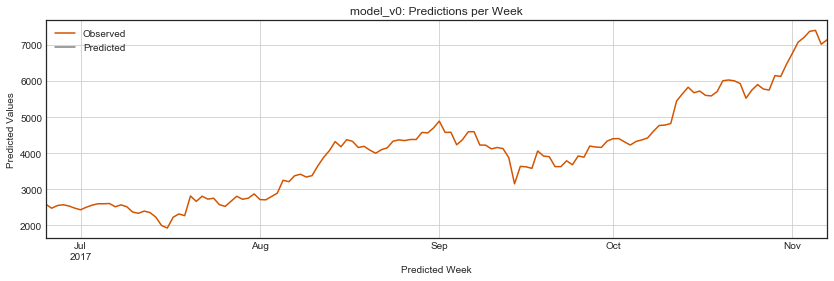

RMSE: 0.0140
MAPE: 0.0%


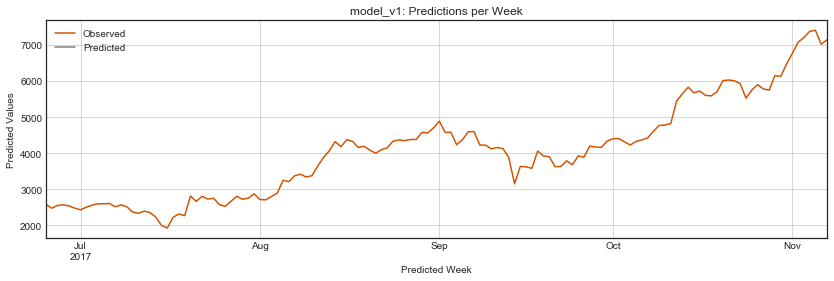

RMSE: 0.2162
MAPE: 0.0%


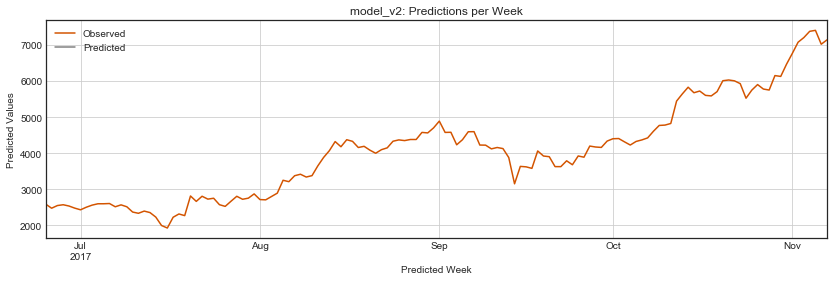

RMSE: 0.0165
MAPE: 0.0%


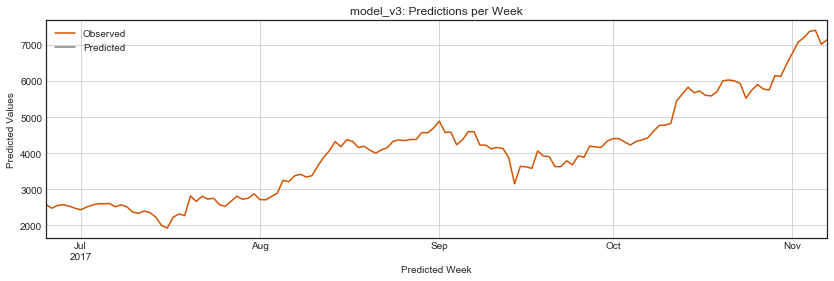

RMSE: 0.0100
MAPE: 0.0%


In [35]:
models = [model_v0, model_v1, model_v2, model_v3]
for i, M in enumerate(models):
    predicted_days = evaluate_model(M, kind='other')
    plot_weekly_predictions(predicted_days, 'model_v{}'.format(i), display_plot=False)

Our first model outperformed all the other models. Take the opportunity and teak the values for the optimization techniques above and attempt to beat the performance of that model!